In [1]:
import matplotlib
matplotlib.use("nbagg")

import matplotlib.pyplot as plt
import numpy as np

In [2]:
import dlc_bci as bci
from utility import * 

## Get Data
Fetches the data from the server and saves it to a folder at the root 

In [3]:
train_input_100, train_target_100, test_input_100, test_target_100 = import100HzData()
train_input, train_target, test_input, test_target = import1000HzData()

<class 'torch.FloatTensor'> torch.Size([316, 28, 50])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 50])
<class 'torch.LongTensor'> torch.Size([100])
<class 'torch.FloatTensor'> torch.Size([316, 28, 500])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 500])
<class 'torch.LongTensor'> torch.Size([100])


In [4]:
print(train_input.shape) 
print(train_target.shape) 
print(test_input.shape) 
print(test_target.shape) 

torch.Size([316, 28, 500])
torch.Size([316])
torch.Size([100, 28, 500])
torch.Size([100])


## Visualize the data

In [5]:
#rawDataForSingleElectrodeVisualization(train_input)

# Preprocessing

Noise removed - Trend Removed - Offset translated - Normalized 

### A "0" Labelled signal - Without Preprocessing

<IPython.core.display.Javascript object>


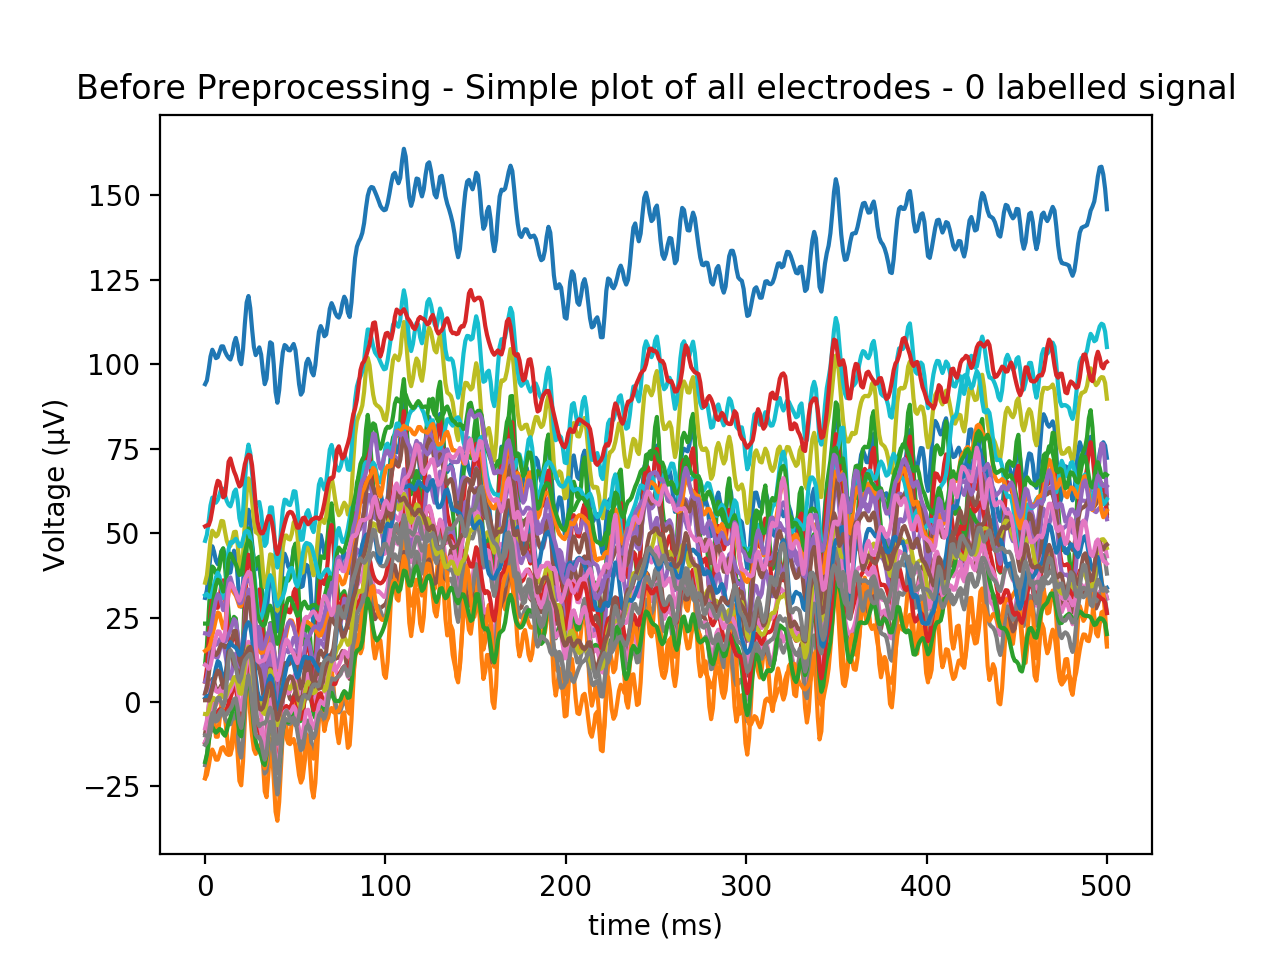

<IPython.core.display.Javascript object>


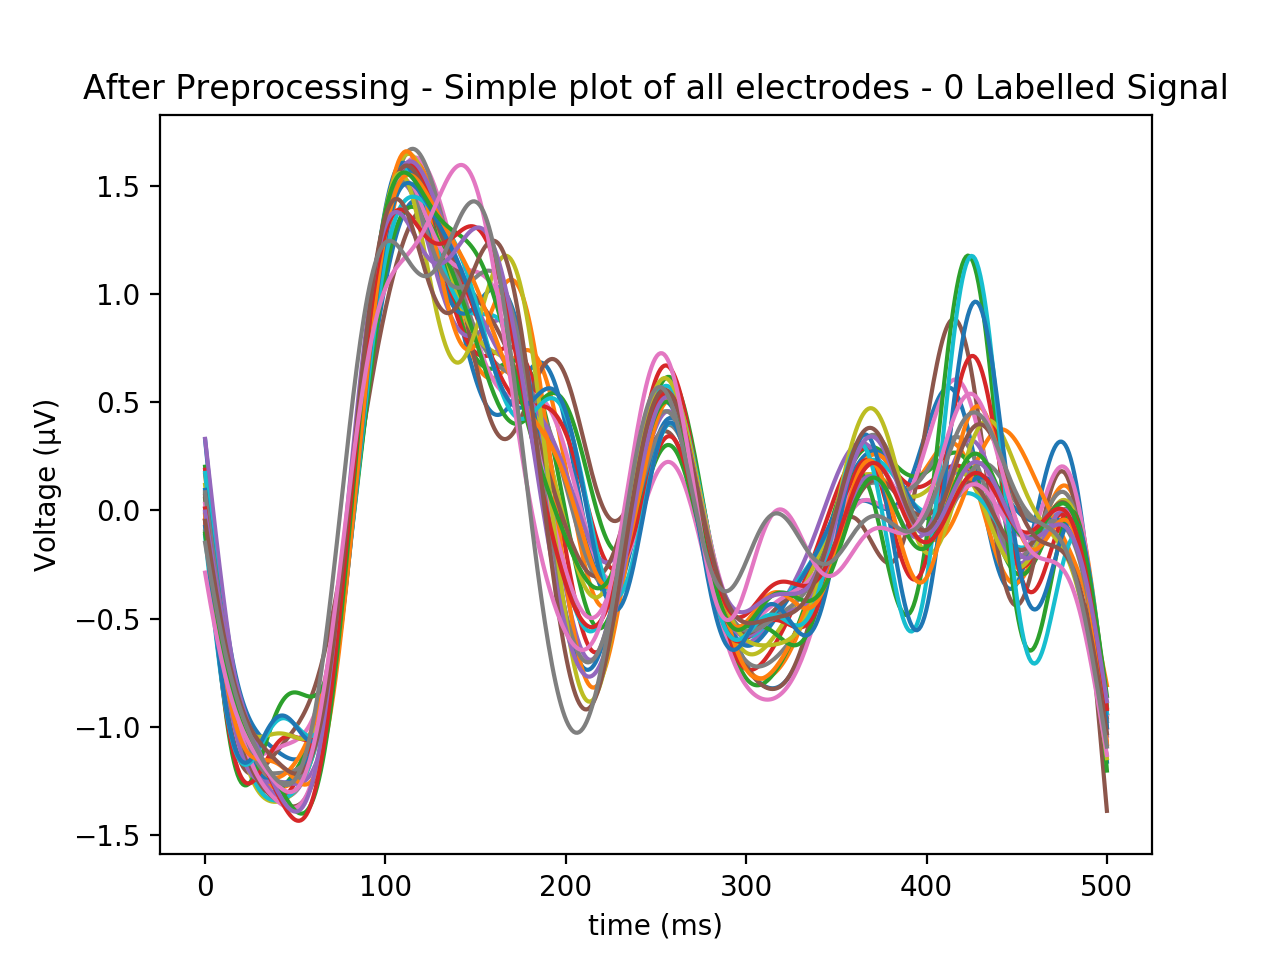

In [6]:
time = np.linspace(0, 500, 500)

rawDataVisualization(train_input, 0, 'Before Preprocessing - Simple plot of all electrodes - 0 labelled signal')
normalizedSingleSignals(train_input, time, 0, True, 'After Preprocessing - Simple plot of all electrodes - 0 Labelled Signal'); 

### A "1" Labelled signal 

<IPython.core.display.Javascript object>


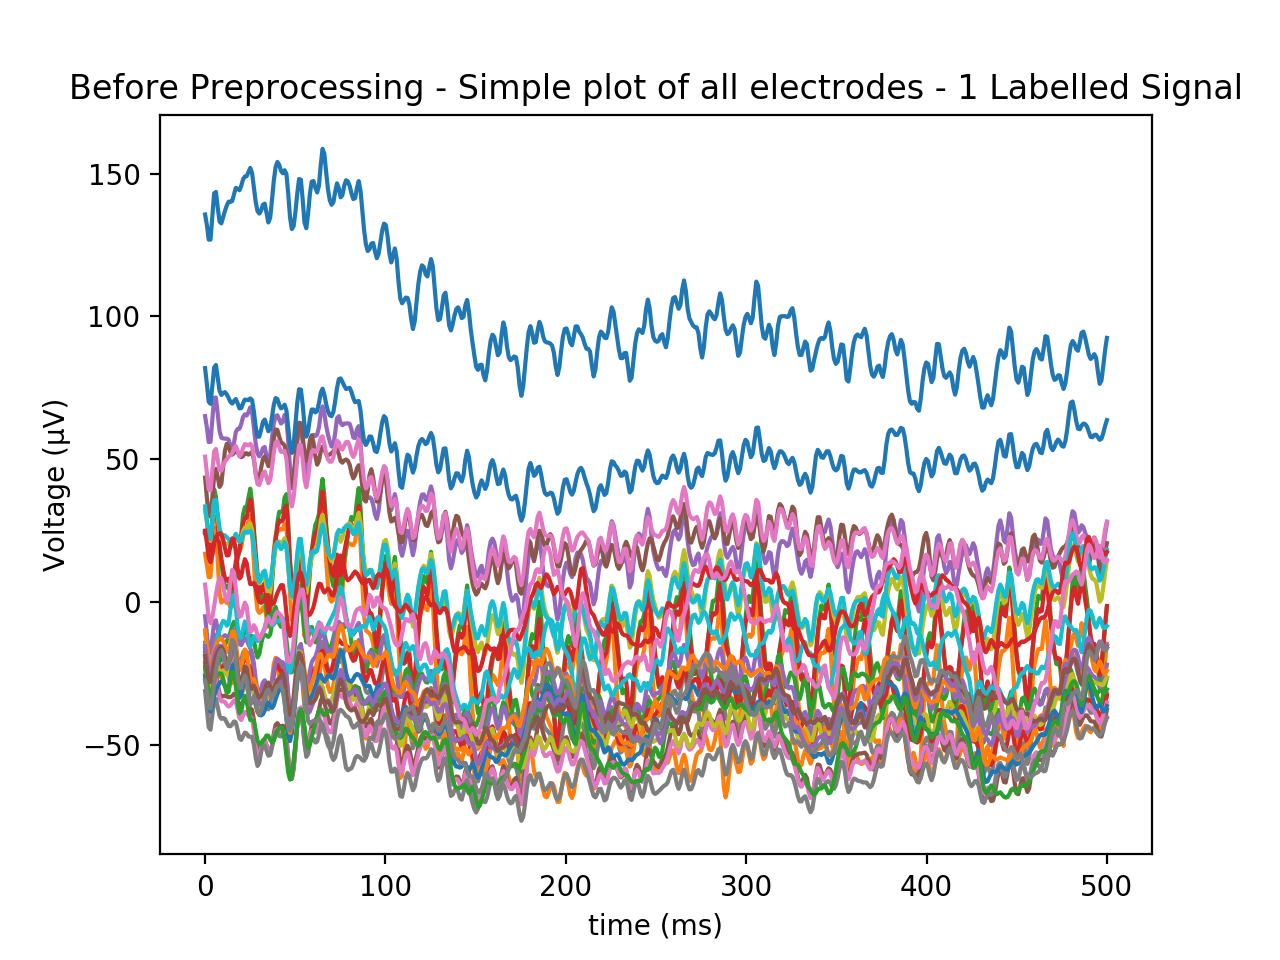

<IPython.core.display.Javascript object>


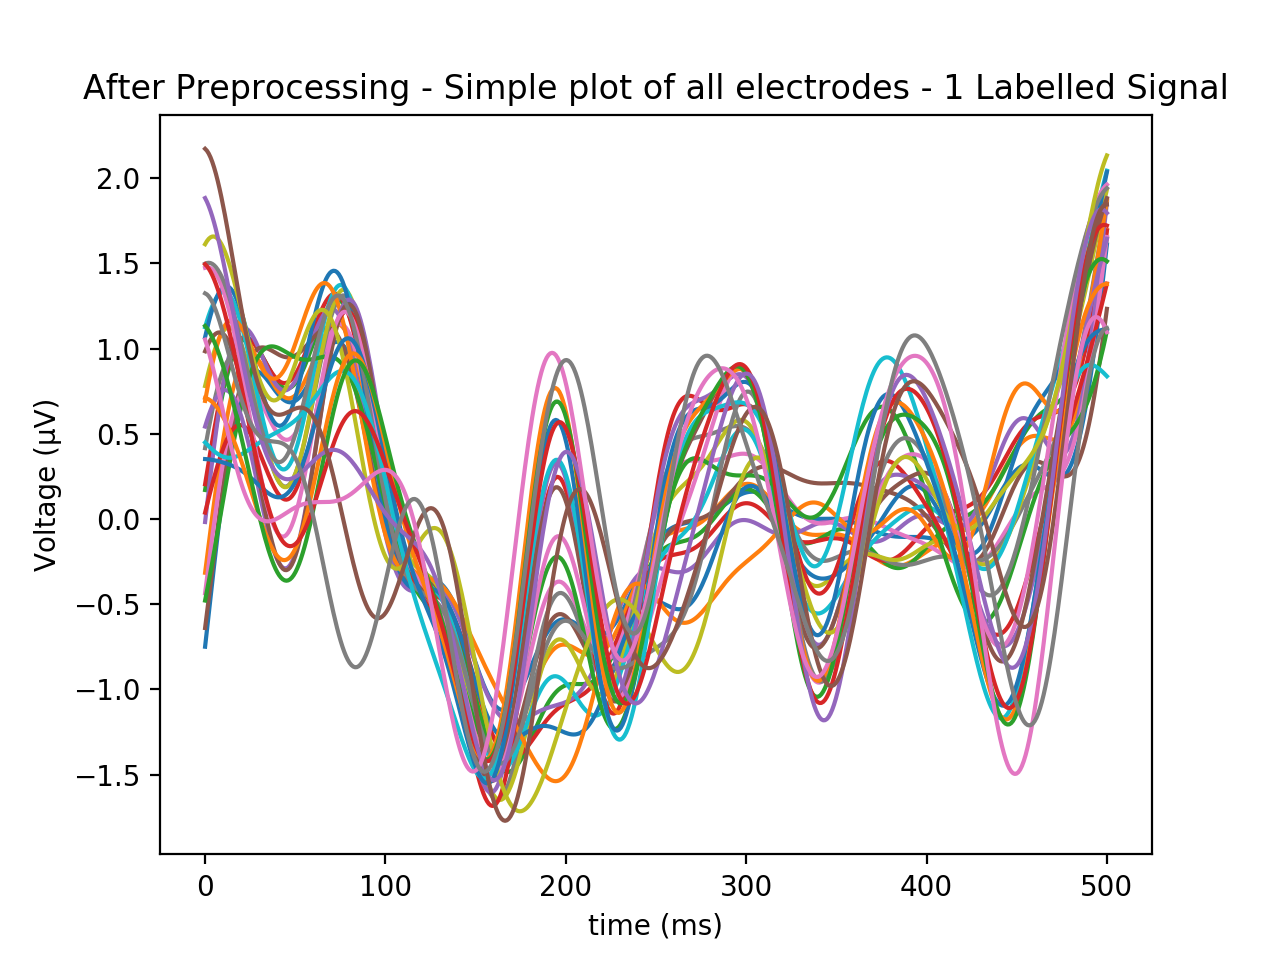

In [7]:
time = np.linspace(0, 500, 500)

rawDataVisualization(train_input, 1, 'Before Preprocessing - Simple plot of all electrodes - 1 Labelled Signal')
normalizedSingleSignals(train_input, time, 1, True, 'After Preprocessing - Simple plot of all electrodes - 1 Labelled Signal');

# Visualize some Normalized signals 

<IPython.core.display.Javascript object>


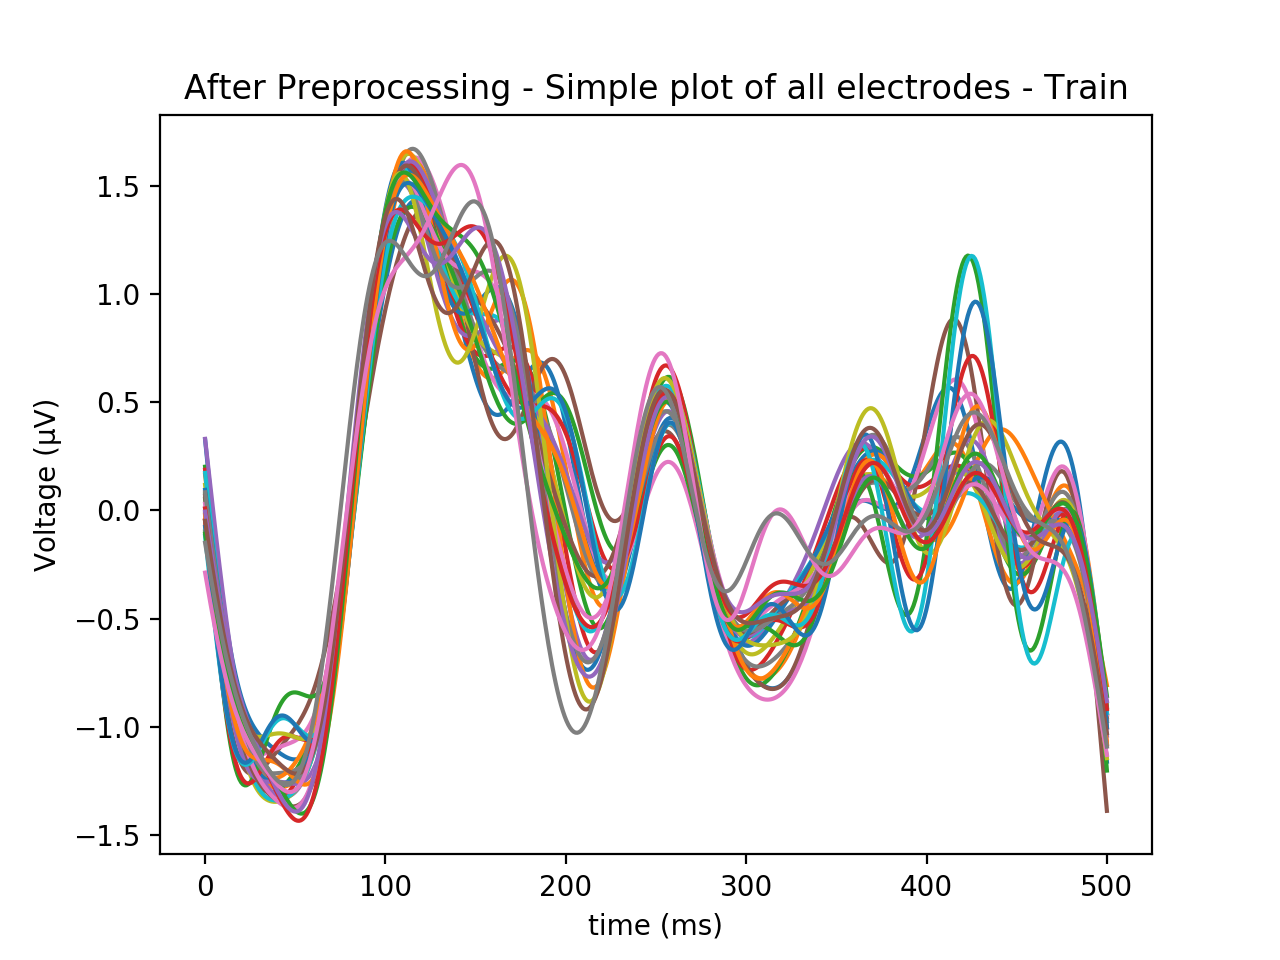

<IPython.core.display.Javascript object>


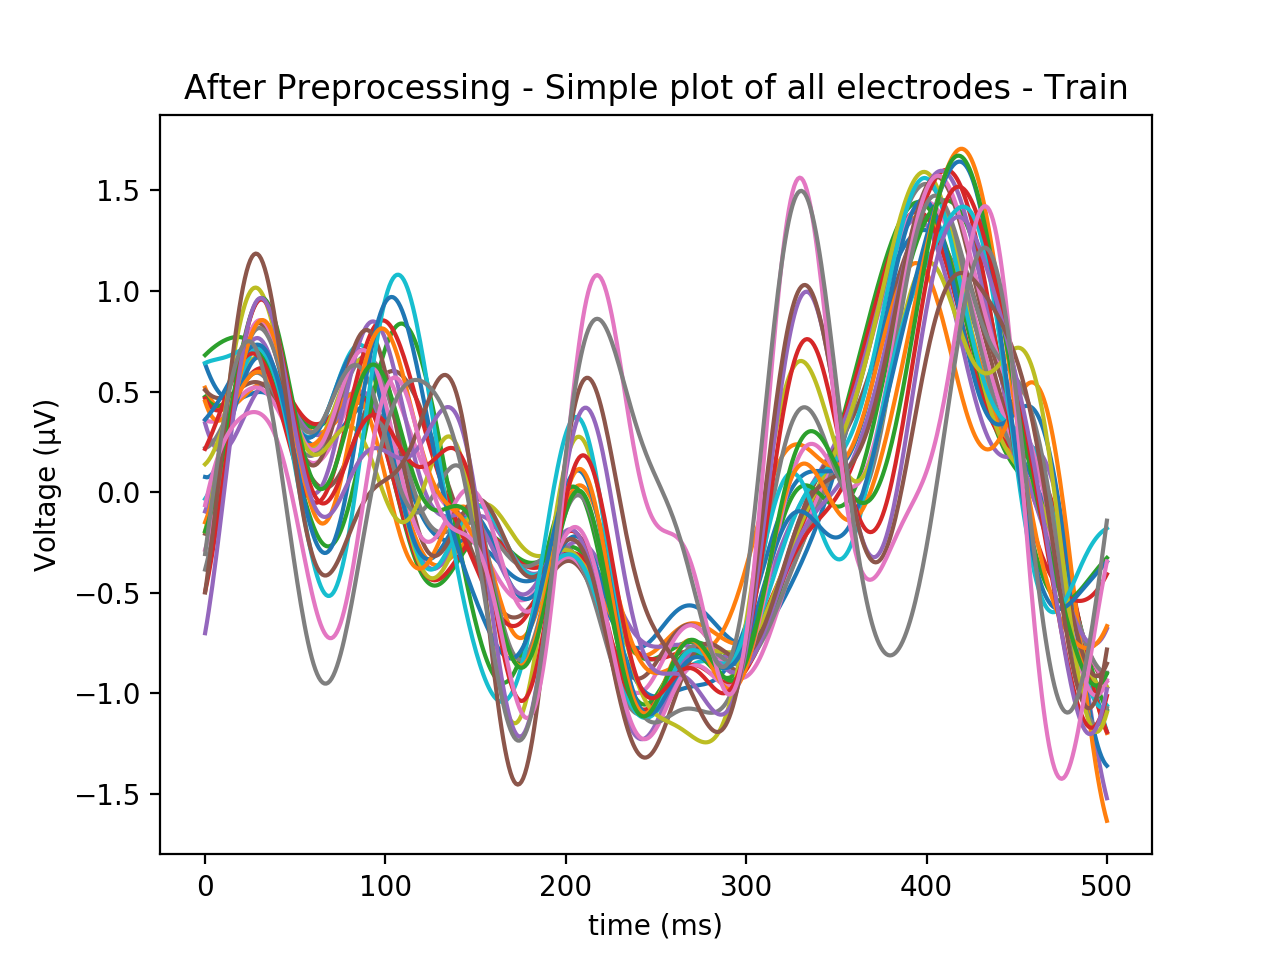

<IPython.core.display.Javascript object>


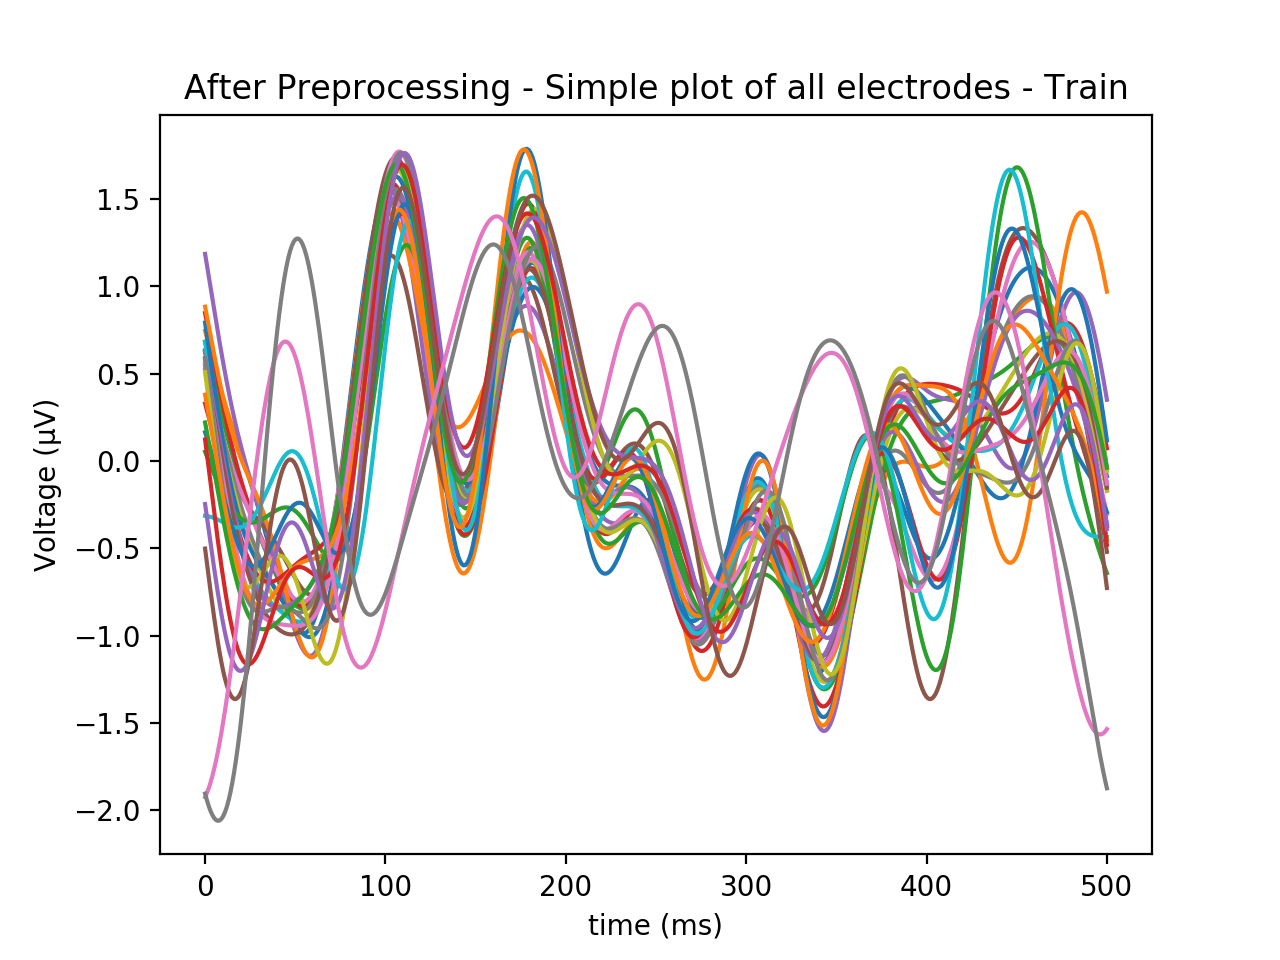

<IPython.core.display.Javascript object>


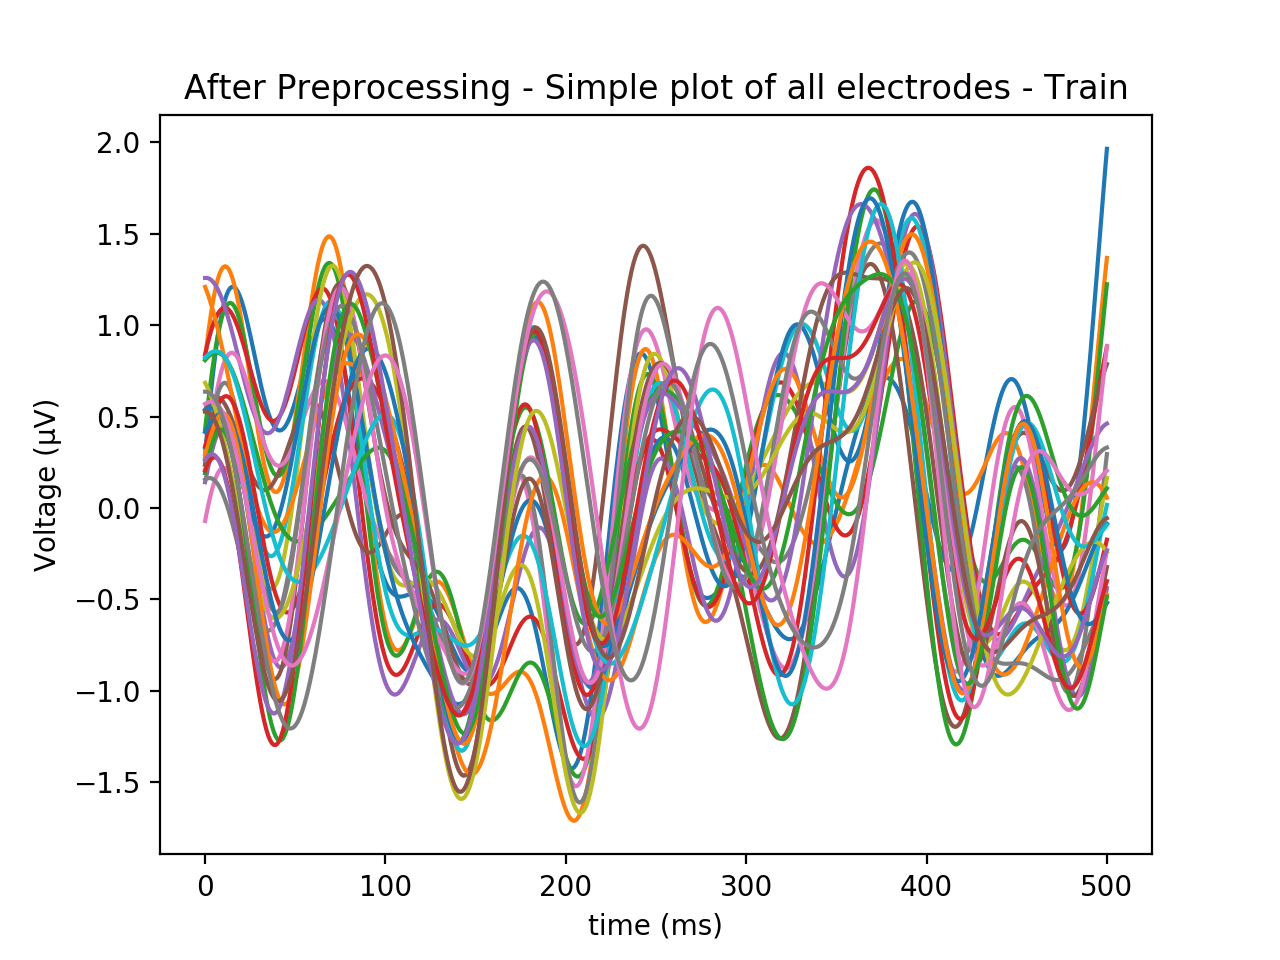

In [8]:
time = np.linspace(0, 500, 500)
normalized_input_train = normalizedSignals(train_input, time, True, 'After Preprocessing - Simple plot of all electrodes - Train', True)

In [9]:
normalized_input_test = normalizedSignals(test_input, time, True, 'After Preprocessing - Simple plot of all electrodes - Test')

# Data Augmentation

Polynomial Baisis

In [10]:
#build a polynomial basis
#poly = build_poly_basis(train_input)

Noise and Shifting 

In [11]:
noise_tensor = np.zeros(np.array(train_input).shape)

print(noise_tensor.shape)

for i in range (316):
    noiseIntensity = 0.1*np.max(np.array(train_input[i,:,:]))
    noise_tensor[i , :, :] = noise(np.array(train_input[i,:,:]), noiseIntensity)
        
final_output = noise_tensor
shiftIntensity = np.linspace(-5, 5, 11)

for j in range(11):
    shifts = np.zeros(train_input.shape)
    for i in range (316):
        shifts[i, :, :] = shift(train_input[i,:,:], int(shiftIntensity[j]))

    final_output= np.concatenate((final_output, shifts), axis=0)

print (final_output.shape)

(316, 28, 500)
(3792, 28, 500)


Data augementation by subsmapling 

In [12]:
#denoise and normalize data (without detrending and so)
tmp = np.array(train_input)

tmp = denoisedSignals(tmp)

#we take the 1000 hz signal and we subsample it with different time steps we downsample to 100Hz but with different initial points. By ding so we have 10 times more samples instead of having ones big weigth for the 1000hz sample

augemented_train_input = tmp[:,:,0::10]

augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,1::10]))
augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,2::10]))
augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,3::10]))
augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,4::10]))
augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,5::10]))
augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,6::10]))
augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,7::10]))
augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,8::10]))
augemented_train_input = np.concatenate((augemented_train_input, tmp[:,:,9::10])) #100 subsampled terms 

noise_tensor = np.zeros(augemented_train_input.shape)

for i in range (augemented_train_input.shape[0]):
    noiseIntensity = 0.1*np.max(augemented_train_input[i,:,:])
    noise_tensor[i , :, :] = noise(augemented_train_input[i,:,:], noiseIntensity)
    
augemented_train_input = noise_tensor

# Neural Net

In [13]:
# Copy the neural network from the Neural Networks section before and modify it to take 18-channel signal (instead of 1-channel images as it was defined).

2. Define a Convolution Neural Network

In [14]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (1,5)) #nn.Conv2d(nbChannels, outputChannels, kxk Square convolution)
        self.pool = nn.MaxPool2d(1, 1)
        self.conv2 = nn.Conv2d(6, 16, (1,5))
        self.dp = nn.Dropout(0.3)
        self.fc1 = nn.Linear(16* 28* 42, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2) #2 output channel one for the left direction and one for the rightweb

    def forward(self, x):
        print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dp(x)
        print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dp(x)
        print(x.shape)
        x = x.view(-1, 16* 28* 42)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [16]:
for epoch in range(300):  # loop over the dataset multiple times
    print ("\nEpoch ", epoch)
    running_loss = 0.0
   
    #inputs = torch.from_numpy(normalized_input_train).float()
    #inputs = train_input #x_train
    inputs = torch.from_numpy(augemented_train_input).float()
    inputs = torch.unsqueeze(inputs,1) # make it float and insert a fake batch dimension
    labels_input = train_target #y_train
    
    labels = labels_input
    for i in range(9): 
        labels = np.concatenate((np.array(labels), np.array(labels_input)), axis = 0)
        
    print(labels.shape)

    # wrap them in Variable
    inputs, labels = Variable(inputs), Variable(torch.from_numpy(labels))

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
 
    optimizer.step()

    running_loss += loss.data[0]
    print("Running loss", running_loss)
    
    # Validation accuracy
    params = ["acc", "auc", "fmeasure"]


Epoch  0
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6943114399909973

Epoch  1
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6940951943397522

Epoch  2
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6942694783210754

Epoch  3
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6943734884262085

Epoch  4
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6941121816635132

Epoch  5
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.694019079208374

Epoch  6
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6942816972732544

Epoch  7
(316

torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.691118597984314

Epoch  59
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6913430690765381

Epoch  60
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6911900043487549

Epoch  61
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6910088062286377

Epoch  62
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6908805966377258

Epoch  63
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6909367442131042

Epoch  64
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.69101482629776

Epoch  65
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Siz

torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6873009204864502

Epoch  117
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6874168515205383

Epoch  118
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6874412894248962

Epoch  119
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6872165203094482

Epoch  120
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6872195601463318

Epoch  121
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.687207818031311

Epoch  122
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6864010095596313

Epoch  123
(3160,)
torch.Size([3160, 1, 28, 50])


Running loss 0.6827278137207031

Epoch  174
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.68218594789505

Epoch  175
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6822760701179504

Epoch  176
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6818001866340637

Epoch  177
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6819016933441162

Epoch  178
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.68168705701828

Epoch  179
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6817604303359985

Epoch  180
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Run

torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.674915075302124

Epoch  232
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6756263971328735

Epoch  233
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6750369071960449

Epoch  234
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6750714778900146

Epoch  235
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6750109791755676

Epoch  236
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6745961904525757

Epoch  237
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6747606992721558

Epoch  238
(3160,)
torch.Size([3160, 1, 28, 50])


Running loss 0.6666377186775208

Epoch  289
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6664329767227173

Epoch  290
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6665823459625244

Epoch  291
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.666077196598053

Epoch  292
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6648757457733154

Epoch  293
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6651950478553772

Epoch  294
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])
Running loss 0.6654031872749329

Epoch  295
(3160,)
torch.Size([3160, 1, 28, 50])
torch.Size([3160, 6, 28, 46])
torch.Size([3160, 16, 28, 42])


5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

# Test Dataset - Prediction 

In [17]:
correct = 0
total = 0

#prediction = torch.from_numpy(normalized_input_test).float() #With normalized input 
prediction = test_input_100 #x_train
prediction_squeezed = torch.unsqueeze(prediction,1) # make it float and insert a fake batch dimension
labels = test_target #y_train

# wrap them in Variable
predictionVar, labelsVar = Variable(prediction_squeezed), Variable(labels)

# forward + backward + optimize
#The outputs are energies for the 10 classes. Higher the energy for a class, the more the network thinks
#that the image is of the particular class. So, let’s get the index of the highest energy:
outputsPred = net(predictionVar) 

_, predicted = torch.max(outputsPred.data, 1) #predicted contains the predicted labels 
total += labels.size(0)
correct += (predicted == labels).sum()

print('Accuracy of the network on the test singals: %d %%' % (100 * correct / total))

torch.Size([100, 1, 28, 50])
torch.Size([100, 6, 28, 46])
torch.Size([100, 16, 28, 42])
Accuracy of the network on the test singals: 51 %
